# Pipeline Bulk

Processed data through bulk ATAC-seq pipeline. Merged peaks using the usual methods (200 bp bins centered at peaks, followed by merging across samples).

In [ ]:
library(DESeq2)
library(ggplot2)
library(ggrepel)
library(reshape2)

In [6]:
cts <- read.csv("./data/bulk_from_pipeline/idr.counts.tsv",sep="\t")
rownames(cts)=paste(cts$chr,cts$start,cts$end,sep='\t')
cts$chrom = NULL
cts$start = NULL
cts$end = NULL
head(cts, 2)
dim(cts)

,D0,D2,D4,D6,D8,D10,D12,D14
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
chr1 51459 51659,17,7,15,12,20,15,47,99
chr1 51689 51889,8,8,12,7,27,34,92,122


[1] 230644      8

Warning message:
“Removed 309 rows containing non-finite values (stat_binhex).”

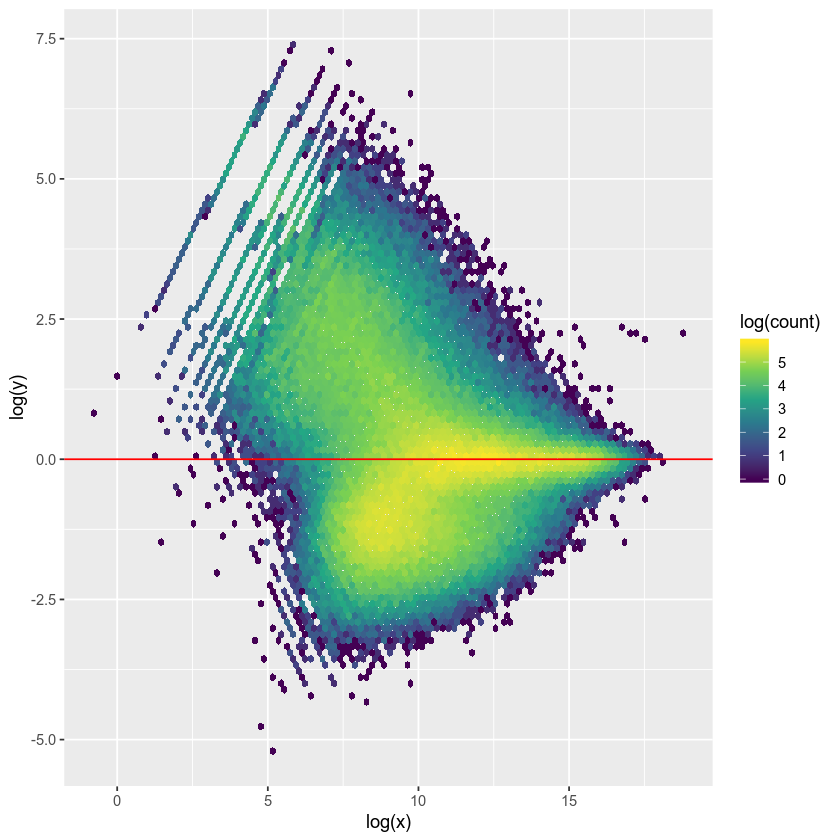

In [55]:
plot_lfc <- function(norm_matrix, S1, S2) {
    df = data.frame(y=(norm_matrix[,S1]/norm_matrix[,S2]),
                x=((norm_matrix[,S1]*norm_matrix[,S2])/2))
    p <- ggplot(df, aes(x=log(x), y=log(y))) + 
    # geom_point(alpha=0.1) +
    stat_binhex(aes(fill=log(..count..)), bins=100)+
    scale_fill_viridis_c() + 
#     coord_cartesian(xlim=c(0, 8)) +
    geom_abline(slope=0, col="red")
    p
}

# seems like iPSCs have more open sites...check diff peaks!
plot_lfc(t(t(cts)/estimateSizeFactorsForMatrix(cts[rowSums(cts<500)==0,])), "D14", "D0")

In [66]:
norm_cts = t(t(cts)/estimateSizeFactorsForMatrix(cts))

In [67]:
log_norm_cts = log10(1+norm_cts)

In [68]:
pca = prcomp(t(log_norm_cts),center=TRUE,scale=FALSE)
pcs=data.frame(pca$x)
pcs$ID=rownames(pcs)
var_explained=round(100*pca$sdev^2/sum(pca$sdev^2),2)
print(var_explained)

[1] 59.01 27.14  6.73  3.48  1.73  1.08  0.82  0.00


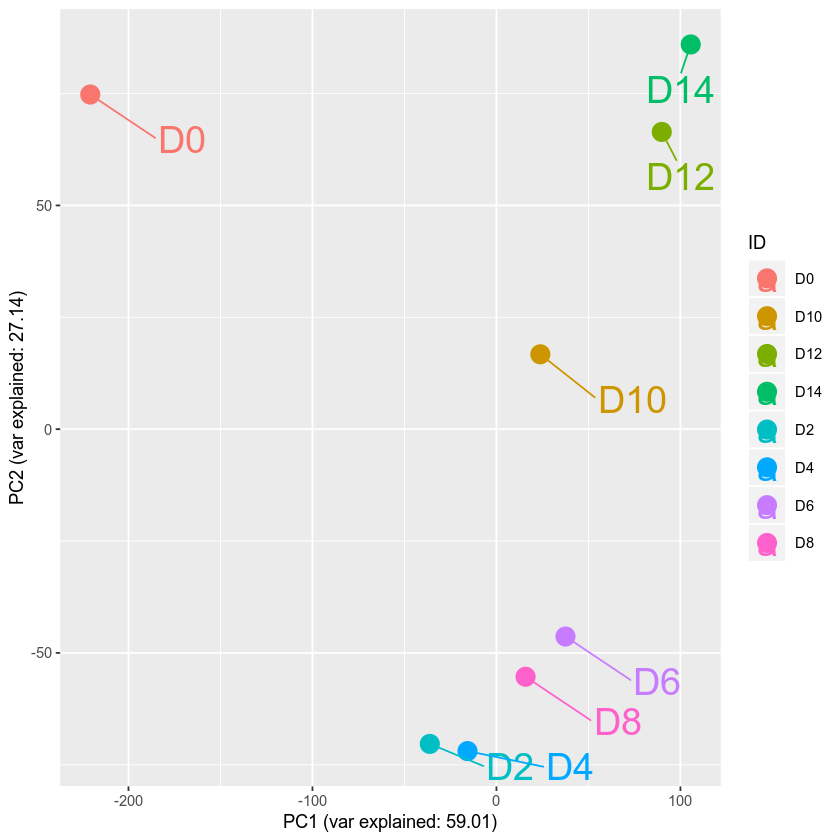

In [69]:
ggplot(data=pcs,aes(x=PC1,y=PC2,color=ID,label=ID))+
geom_point(size=5)+
geom_text_repel(size=8, nudge_x=50, nudge_y=-10)+
labs(x=sprintf("PC1 (var explained: %.2f)", var_explained[1]), y = sprintf("PC2 (var explained: %.2f)", var_explained[2]))

## Clustering

In [ ]:
library(ClusterR)
library(viridis)
library(scales)

In [17]:
# ADD RAND SEED - not required

km_mb = MiniBatchKmeans(log_norm_cts, 
                        batch_size = 1000,
                        clusters=25,
                        num_init = 10, 
                        verbose = FALSE)

In [18]:
# reorder based on hierarchical clustering
pr_mb = predict_MBatchKMeans(log_norm_cts, km_mb$centroids)
# distance    = dist(km_mb$centroids)
distance    = dist(t(scale(t(km_mb$centroids))))
cluster     = hclust(distance, method="ward")
dendrogram  = as.dendrogram(cluster)
rowInd = rev(order.dendrogram(dendrogram))
pr_mb = order(rowInd)[pr_mb]

The "ward" method has been renamed to "ward.D"; note new "ward.D2"


In [19]:
table(pr_mb)

pr_mb
    1     2     3     4     5     6     7     8     9    10    11    12    13 
 5707  3969  5641  3133  6755  5343  3088 16509 12908  9799  6355  3623  4619 
   14    15    16    17    18    19    20    21    22    23    24    25 
 5232  4978 15069 18005 13553  8888 16078 12460 15142 10726 14852  8212 

In [20]:
log_norm_cts_clustered = log_norm_cts[order(pr_mb),]
head(log_norm_cts_clustered, 2)

,D0,D2,D4,D6,D8,D10,D12,D14
chr1 1580169 1580369,1.215938,2.167767,1.968286,2.165341,2.120805,2.204158,2.105369,2.184654
chr1 2285011 2285299,1.463523,1.977518,2.095851,2.480875,2.145575,2.190009,2.299925,2.283774


## Plotting

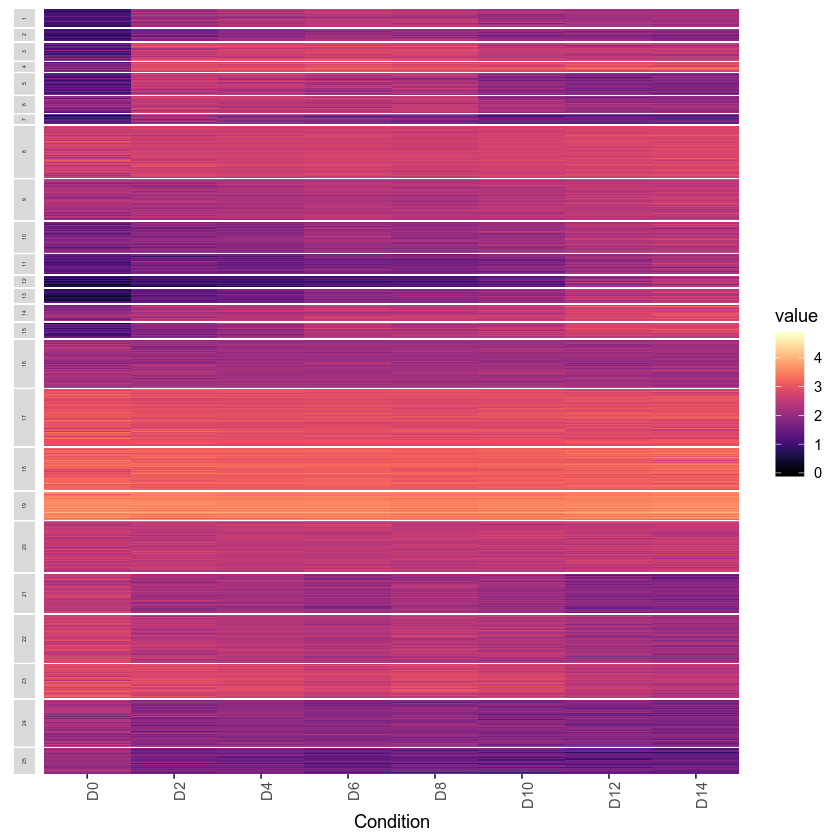

In [21]:
idxs = seq(1, nrow(log_norm_cts_clustered), 1)
ggplot(data = melt(log_norm_cts_clustered[idxs,]), mapping = aes(x = Var2,
                                                         y = Var1,
                                                         fill = value)) +
geom_tile()  + ylab(NULL) + xlab("Condition") +  
geom_raster(aes(fill=value)) +
# scale_fill_viridis(limits=c(3.9, 8), oob=squish, option = "A") +
scale_fill_viridis(option="A") + 
facet_grid(sort(pr_mb)[idxs] ~ ., switch = "y", scales = "free_y", space = "free_y") +
# theme_classic() +
theme(axis.text.x=element_text(angle=90,hjust=1),
      axis.text.y=element_blank(),
      axis.ticks.y=element_blank(),
      panel.spacing.y = unit(0.03, "cm"),
      strip.text.y = element_text(size = 3))
#       strip.background = element_rect(size = 0.1))

# ggsave(sprintf("figs/%s_heatmap_pipeline_n%d.jpeg", format(Sys.Date(), format='%Y%m%d'), length(table(pr_mb))),
#        dpi=1000)

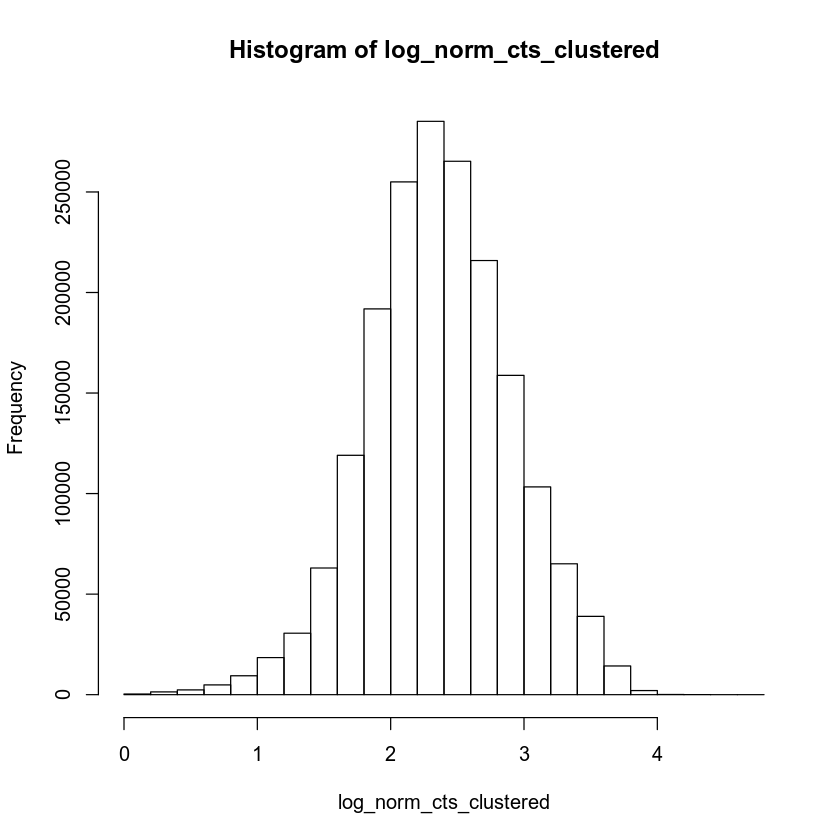

In [22]:
# See distribution of scores
hist(log_norm_cts_clustered)

## Writing BED files for some clusters

In [37]:
CLUSTER_IDX = 1
NORM = 'heatmap_idr'
BED_PATH = sprintf("beds/%s_%s_n%d/idx%d.bed", format(Sys.Date(), format='%Y%m%d'), NORM, length(table(pr_mb)), CLUSTER_IDX)
# rownames(vsd_assay_to_cluster_normalized)[(which(pr_mb==CLUSTER_IDX))]
BED_PATH

[1] "beds/20200121_heatmap_idr_n25/idx1.bed"

In [35]:
for (i in seq(1,length(table(pr_mb)))){
BED_PATH = sprintf("beds/%s_%s_n%d/idx%d.bed", format(Sys.Date(), format='%Y%m%d'), NORM, length(table(pr_mb)), i)
fileConn = file(BED_PATH)
writeLines(rownames(log_norm_cts)[(which(pr_mb==i))], fileConn)
close(fileConn)}

In [36]:
ALL_PEAKS_BED_PATH = sprintf("beds/%s_%s_n%d/all_peaks.bed", format(Sys.Date(), format='%Y%m%d'), NORM, length(table(pr_mb)))
print(ALL_PEAKS_BED_PATH)
fileConn = file(ALL_PEAKS_BED_PATH)
writeLines(rownames(log_norm_cts), fileConn)
close(fileConn)

[1] "beds/20200121_heatmap_overlap_n25/all_peaks.bed"


Commands for motif analysis:

```for i in {1..5} ; do if [ ! -d homer/20200119_heatmap_2kb_intersect_n25/idx$i ] ; then findMotifsGenome.pl beds/20200119_heatmap_2kb_intersect_n25/idx$i.bed ~/genomes/hg38/GRCh38_no_alt_analysis_set_GCA_000001405.15.fasta homer/20200119_heatmap_2kb_intersect_n25/idx$i -nomotif -size given -bg beds/20200119_heatmap_2kb_intersect_n25/all_peaks.bed -p 8 ; fi ; done```